In [1]:
from manim import *
from numpy import linalg as npl
import math
import matplotlib.pyplot as plt
import jupyter_capture_output
from scipy.interpolate import make_interp_spline, BSpline
from multiprocessing import Process

video_scene = " -v WARNING --progress_bar None --disable_caching tsunami_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s tsunami_Scene"

Manim Community v0.16.0.post0

Jupyter Capture Output v0.0.8


In [61]:
# Parameter des Ozeans
OCEAN_HEIGHT = 5000;                               # generelle Wassertiefe des Ozeans
OCEAN_HEIGHT_RIFF = 20;                            # Wassertiefe am Riff

OCEAN_X_LEFT = -1000;                            # linker Rand des Ozeans
OCEAN_X_RIGHT = 0;                                 # rechter Rand des Ozeans
OCEAN_X_RIFF_LEFT = -700;                        # linker Rand des Riffs
OCEAN_X_BEACH_LEFT = -550;                       # linker Rand des Strandes
OCEAN_X_BEACH_RIGHT = -450;                      # rechter Rand des Strandes
OCEAN_X_RIFF_RIGHT = -300;                       # rechter Rand des Riffs


# Profil des Meeresbodes
def height_ocean(x):
    if (OCEAN_X_LEFT <= x and x < OCEAN_X_RIFF_LEFT):
        return OCEAN_HEIGHT
    elif (OCEAN_X_RIFF_LEFT <= x and x < OCEAN_X_BEACH_LEFT):
        return OCEAN_HEIGHT + (OCEAN_HEIGHT_RIFF-OCEAN_HEIGHT) * (np.sin(PI/2 * (x-OCEAN_X_RIFF_LEFT) / (OCEAN_X_BEACH_LEFT-OCEAN_X_RIFF_LEFT)))**2
    elif (OCEAN_X_BEACH_LEFT <= x and x < OCEAN_X_BEACH_RIGHT):
        return OCEAN_HEIGHT_RIFF
    elif (OCEAN_X_BEACH_RIGHT <= x and x < OCEAN_X_RIFF_RIGHT):
        return OCEAN_HEIGHT_RIFF - (OCEAN_HEIGHT_RIFF-OCEAN_HEIGHT) * (np.sin(PI/2 * (OCEAN_X_BEACH_RIGHT-x) / (OCEAN_X_BEACH_RIGHT-OCEAN_X_RIFF_RIGHT)))**2
    elif (OCEAN_X_RIFF_RIGHT <= x and x < OCEAN_X_RIGHT):
        return OCEAN_HEIGHT
    else:
        return -5000
    

riff_x_plot = np.linspace(OCEAN_X_LEFT, OCEAN_X_RIGHT-1, 1000)
riff_h_plot = np.array([5000 - height_ocean(riff_x_plot_i) for riff_x_plot_i in riff_x_plot]) 


Output saved by creating file at animations/tsumani/tsunami.mp4.


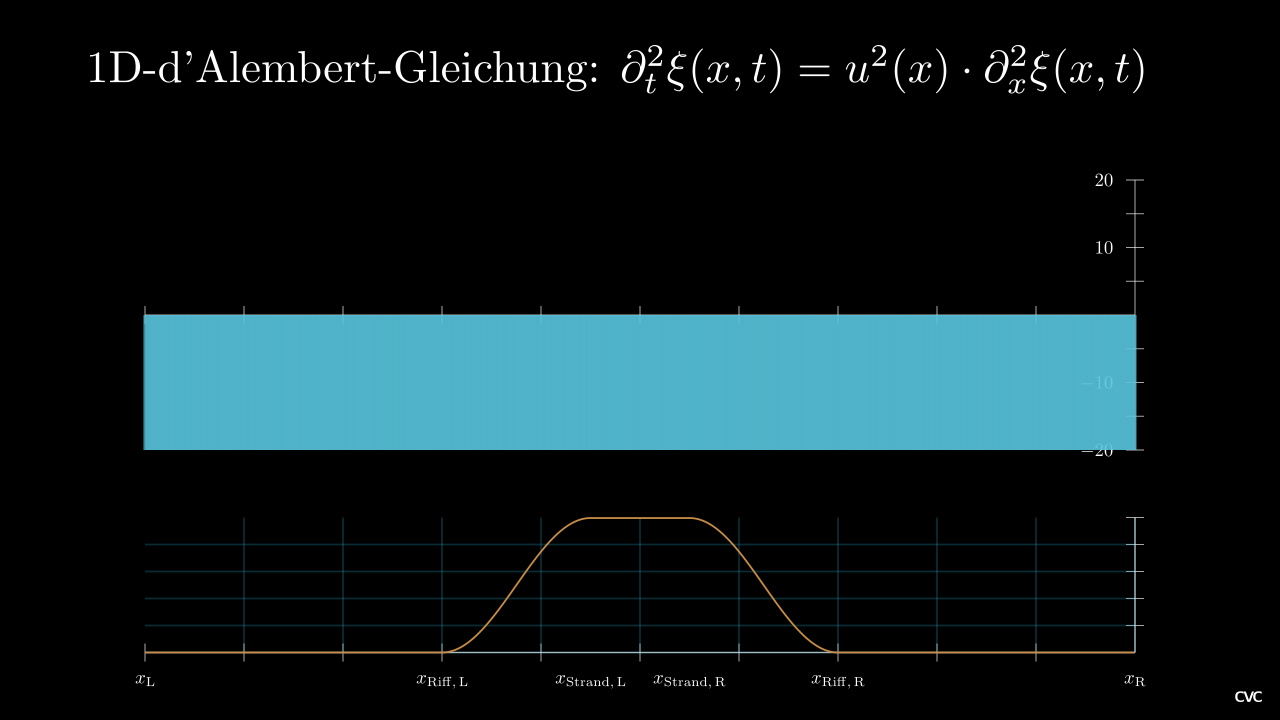

In [94]:
%%capture_video --path "animations/tsumani/tsunami.mp4"
%%manim -qm --fps 60 $video_scene


### Datenerzeugung ###
A26_Tsunami_data = np.loadtxt("external_data/A26_Tsunami_data.csv", delimiter = ",", skiprows = 0)

x_ocean_array = A26_Tsunami_data[0,:] / 1000
wave_iter_list = []

# Erzeugung des Iter-Arrays
for i in range(len(x_ocean_array)):
    wave_iter_list.append(iter(A26_Tsunami_data[1::10,i]))
### Datenerzeugung ###


class tsunami_Scene(Scene):
    def construct(self):
        CVC = Text('CVC', font_size = 12, weight = BOLD, color = WHITE, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        self.add(CVC)


        # Header
        text_heat = Tex(r"1D-d'Alembert-Gleichung: $\partial_t^2\xi(x, t)=u^2(x)\cdot\partial_x^2\xi(x, t)$", font_size = 48).align_on_border(UP + LEFT, buff = 0.5).shift(0.5 * RIGHT)
        self.add(text_heat)


        # Riff: Coordinate System
        x_riff_range = [OCEAN_X_LEFT, OCEAN_X_RIGHT, 100]
        y_riff_range = [0, OCEAN_HEIGHT, 1000]

        x_riff_length = 11
        y_riff_length = 1.5

        x_riff_dict = dict(zip(
            [OCEAN_X_LEFT, OCEAN_X_RIFF_LEFT, OCEAN_X_BEACH_LEFT, OCEAN_X_BEACH_RIGHT, OCEAN_X_RIFF_RIGHT, OCEAN_X_RIGHT], 
            [r"$x_\mathrm{L}$", r"$x_\mathrm{Riff,\,L}$", r"$x_\mathrm{Strand,\,L}$", r"$x_\mathrm{Strand,\,R}$", r"$x_\mathrm{Riff,\,R}$", r"$x_\mathrm{R}$"]))
        npla_riff = NumberPlane(
            x_range = x_riff_range, y_range = y_riff_range, x_length = x_riff_length, y_length = y_riff_length,
            axis_config = {"include_numbers": False, "stroke_opacity": 0.25}, background_line_style = {"stroke_opacity": 0.25}, ).shift(2.5 * DOWN)
        ax_riff = Axes(
            x_range = x_riff_range, y_range = y_riff_range, x_length = x_riff_length, y_length = y_riff_length, 
            axis_config = {"stroke_width": 1, "stroke_opacity": 0.75}, tips = False).add_coordinates(x_riff_dict, font_size = 20).shift(2.5 * DOWN)
        line_graph_riff = ax_riff.plot_line_graph(x_values = riff_x_plot, y_values = riff_h_plot, line_color = GOLD_E, add_vertex_dots = False, stroke_width = 2)

        riff_coordinate_system = VGroup(ax_riff, npla_riff, line_graph_riff)
        self.add(riff_coordinate_system)


        # Wave: Coordinate System
        x_wave_range = [OCEAN_X_LEFT, OCEAN_X_RIGHT, 100]
        y_wave_range = [-20, 20, 5]

        x_wave_length = 11
        y_wave_length = 3

        y_wave_dict = dict(zip([-20, -10, 10, 20], [-20, -10, 10, 20]))
        ax_wave = Axes(
            x_range = x_wave_range, y_range = y_wave_range, x_length = x_wave_length, y_length = y_wave_length, 
            axis_config = {"stroke_width": 1, "stroke_opacity": 0.75}, tips = False).add_coordinates([], y_wave_dict, font_size = 20).shift(0.5 * UP)

        wave_coordinate_system = VGroup(ax_wave)
        self.add(wave_coordinate_system)


        # Wave
        wave_line_list = []
        for i, wave_iter in enumerate(wave_iter_list):

            x_wave = x_ocean_array[i]
            y_wave = next(wave_iter)

            wave_line = Line(start = ax_wave.c2p(x_wave, y_wave, 0), end = ax_wave.c2p(x_wave, -20, 0), color = BLUE, stroke_opacity = 0.5)
            wave_line_list.append(wave_line)
            self.add(wave_line_list[i])
